# Setup Libraries

Needed in google colab

In [1]:
pip install yfinance

     |████████████████████████████████| 63 kB 1.4 MB/s 
     |████████████████████████████████| 6.4 MB 47.6 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [2]:
# Provides ways to work with large multidimensional arrays
import numpy as np 
# Allows for further data manipulation and analysis
import pandas as pd 
import matplotlib.pyplot as plt # Plotting
import matplotlib.dates as mdates # Styling dates
#import matplotlib.mlab as mlab 
%matplotlib inline

# statistical calculation
#from scipy.stats import norm

import datetime as dt # For defining dates

import time

import yfinance as yf

# Get Stock Data

In [36]:
all_stocks = ["^GSPC", "^FTLC", "^RUT", "IEUS", "GOVT", "IGOV", "SIVR", "SGOL"]

In [37]:
def get_all_closes_of_stocks(tickers):
  i = 0
  stock_list = pd.DataFrame()
  for ticker in tickers:
    stock = yf.Ticker(ticker)        
    data = stock.history(start="2012-02-24",end ="2022-02-25")
    data.drop(data.columns[[0,1,2,4,5,6]], axis=1, inplace=True) # Just gets the adjacent close for each asset
    data.columns = [ticker]
    stock_list[ticker] = data.iloc[:,0]
  return stock_list.dropna()
stock_data = get_all_closes_of_stocks(all_stocks)
print(stock_data)

                  ^GSPC        ^FTLC  ...       SIVR       SGOL
Date                                  ...                      
2012-02-24  1365.739990  3144.399902  ...  35.110001  17.559000
2012-02-27  1367.589966  3133.399902  ...  35.099998  17.504000
2012-02-28  1372.180054  3141.199951  ...  36.610001  17.688000
2012-02-29  1365.680054  3112.399902  ...  34.240002  16.750000
2012-03-01  1374.089966  3142.899902  ...  35.180000  16.987000
...                 ...          ...  ...        ...        ...
2022-02-17  4380.259766  4240.200195  ...  22.959999  18.219999
2022-02-18  4348.870117  4222.799805  ...  23.040001  18.200001
2022-02-22  4304.759766  4201.799805  ...  23.260000  18.240000
2022-02-23  4225.500000  4198.799805  ...  23.680000  18.330000
2022-02-24  4288.700195  4042.899902  ...  23.270000  18.219999

[2399 rows x 8 columns]


# Backtesting

## Equal Allocation Portfolio Benchmark with Yearly rebalancing

Note to self for now you multiply column by column. If indecies don't match you won't multiply

In [38]:
portfolio_weights = pd.Series([0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125], index=all_stocks) # Defining an equally weighted portfolio
initial_investment = 10000 # 10'000 dollar invesment. Can Change to 100'000 later 
trading_year = 252 # Number of trading days in a year
stock_returns = stock_data.pct_change() 

In [39]:
# balance every x number of years
total_portfolio_value = []
investment_total = initial_investment

for i in range (0,len(stock_data)-1):

  if i == 0:
    weighted_portfolio = portfolio_weights * investment_total # Calculate the dollars invested in each asset in the portfolio
    num_of_shares = weighted_portfolio / stock_data.iloc[i,:] # Calculate the number of shares owned of each asset in the portfolio
    portfolio_position_values = num_of_shares * stock_data.iloc[i:(i+trading_year),:] # share * share price = position value and it is done for each day in the trading year for all assets

  elif i % trading_year == 0: # Each trading year it rebalances the portfolio
    investment_total = (num_of_shares * stock_data.iloc[i,:]).sum() # Calcualtes the current value of all assets in the portfolio
    weighted_portfolio = portfolio_weights * investment_total
    num_of_shares = weighted_portfolio / stock_data.iloc[i,:]
    tmp_pd = num_of_shares * stock_data.iloc[i:(i+trading_year),:] 
    portfolio_position_values = (pd.concat([portfolio_position_values,tmp_pd])) # Adds the new trading year data to the dataframe of the previous years

  total_portfolio_value.append(num_of_shares * stock_data.iloc[i,:])


portfolio_position_values['Total'] = portfolio_position_values.sum(axis=1)
portfolio_position_values

,^GSPC,^FTLC,^RUT,IEUS,GOVT,IGOV,SIVR,SGOL,Total
Date,,,,,,,,,
2012-02-24,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,10000.000000
2012-02-27,1251.693199,1245.627147,1249.606961,1246.151860,1250.000000,1248.513688,1249.643900,1246.084607,9987.321362
2012-02-28,1255.894299,1248.727917,1245.283711,1257.346846,1250.000000,1258.296800,1303.403588,1259.183304,10078.136464
2012-02-29,1249.945143,1237.278972,1225.844125,1244.052724,1250.000000,1252.105163,1219.025957,1192.408450,9870.660534
2012-03-01,1257.642355,1249.403702,1232.313869,1242.303371,1250.000000,1227.199029,1252.492157,1209.280105,9920.634587
...,...,...,...,...,...,...,...,...,...
2022-02-17,1981.608563,2048.421089,1820.631943,1777.702664,1932.952667,1848.487878,2030.954573,2174.417438,15615.176816
2022-02-18,1967.408036,2040.015041,1803.790938,1756.735893,1937.490219,1846.198350,2038.031232,2172.030764,15561.700473
2022-02-22,1947.452724,2029.870038,1777.613861,1720.952637,1938.246333,1844.290361,2057.491539,2176.804339,15492.721833


### Plot the Portfolio 

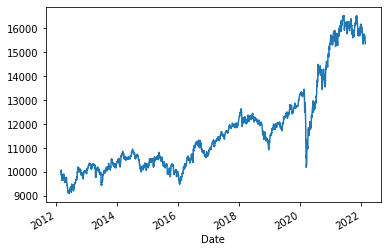

In [40]:
portfolio_position_values['Total'].plot()

### Plot the Individual Assets

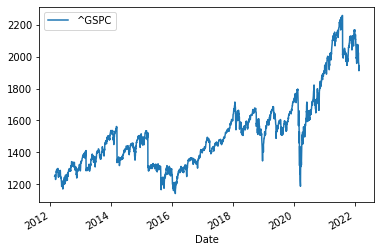

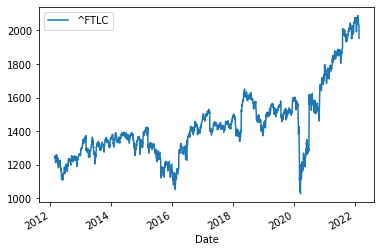

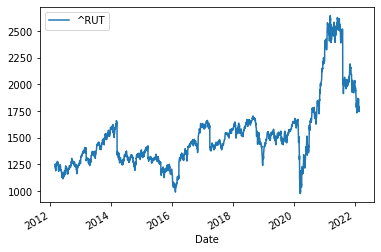

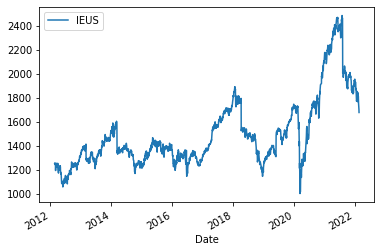

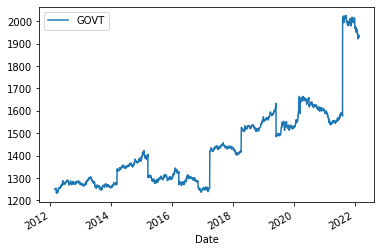

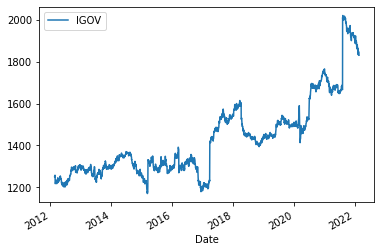

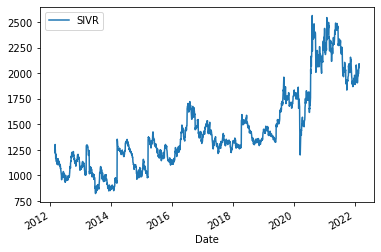

In [41]:
for i in range(1,8):
  portfolio_position_values.iloc[:,(i-1):i].plot()

## Benchmark on the Test Year Only

In [42]:
weighted_portfolio = portfolio_weights * initial_investment # Calculate the dollars invested in each asset in the portfolio
num_of_shares = weighted_portfolio / stock_data.iloc[(-trading_year),:] # Calculate the number of shares owned of each asset in the portfolio
portfolio_test_values = num_of_shares * stock_data.iloc[(-trading_year):,:] # share * share price = position value and it is done for each day in the trading year for all assets
portfolio_test_values['Total'] = portfolio_test_values.sum(axis=1)
portfolio_test_values

,^GSPC,^FTLC,^RUT,IEUS,GOVT,IGOV,SIVR,SGOL,Total
Date,,,,,,,,,
2021-02-02,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,10000.000000
2021-02-03,1251.260961,1249.296327,1254.799117,1251.566610,1246.766398,1248.388880,1269.592457,1247.875441,10019.546192
2021-02-04,1264.841300,1249.296327,1279.619686,1254.308370,1245.842627,1242.174536,1247.061061,1220.963183,10004.107090
2021-02-05,1269.771013,1249.832467,1297.578679,1267.429097,1243.994905,1247.928611,1271.061927,1233.002849,10080.599547
2021-02-08,1279.166491,1255.428065,1330.364821,1274.283229,1244.456924,1249.309507,1293.593230,1245.042514,10171.644781
...,...,...,...,...,...,...,...,...,...
2022-02-17,1430.967335,1420.750042,1178.332896,1278.266468,1192.264485,1119.230289,1124.608085,1290.368251,10034.787851
2022-02-18,1420.712792,1414.919750,1167.433214,1263.190200,1195.063292,1117.844015,1128.526670,1288.951923,9996.641856
2022-02-22,1406.302580,1407.883348,1150.491123,1237.460062,1195.529670,1116.688758,1139.302499,1291.784714,9945.442755


### Plot the portfolio

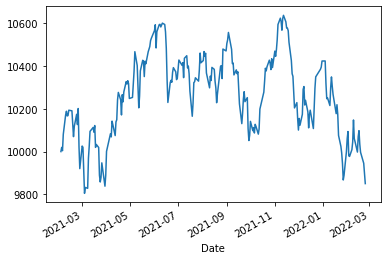

In [43]:
portfolio_test_values['Total'].plot()

### Plot the Individual Assets

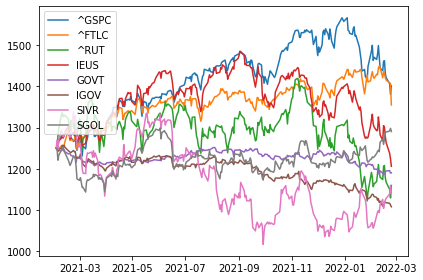

In [53]:
# Plotted on the same graph to see general trend
figure = plt.figure()
axis = plt.plot(portfolio_test_values.iloc[:,0:1], label='^GSPC')
axis = plt.plot(portfolio_test_values.iloc[:,1:2], label='^FTLC')
axis = plt.plot(portfolio_test_values.iloc[:,2:3], label='^RUT')
axis = plt.plot(portfolio_test_values.iloc[:,3:4], label='IEUS')

axis = plt.plot(portfolio_test_values.iloc[:,4:5], label='GOVT')
axis = plt.plot(portfolio_test_values.iloc[:,5:6], label='IGOV')
axis = plt.plot(portfolio_test_values.iloc[:,6:7], label='SIVR')
axis = plt.plot(portfolio_test_values.iloc[:,7:8], label='SGOL')
plt.tight_layout()
plt.legend()
plt.show()

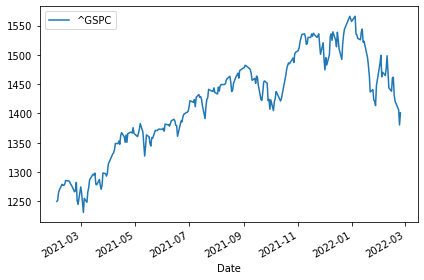

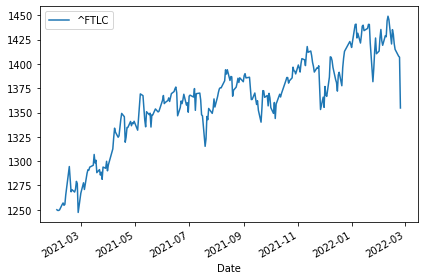

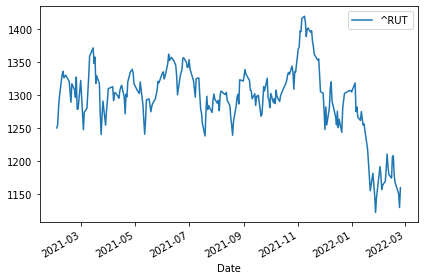

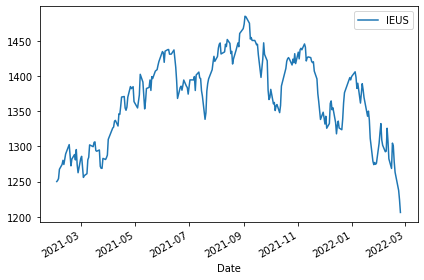

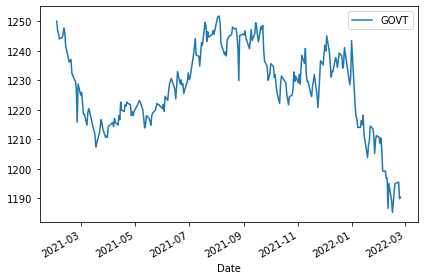

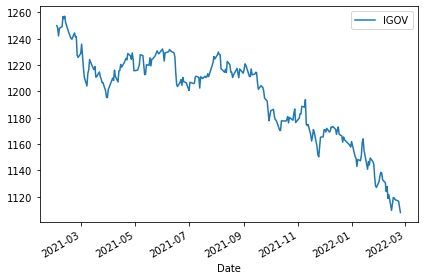

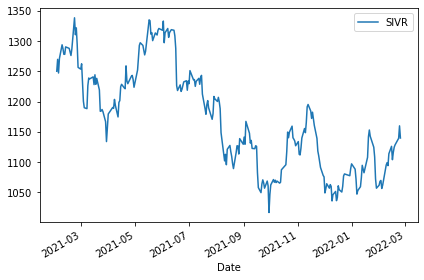

In [45]:
for i in range(1,8):
  portfolio_test_values.iloc[:,(i-1):i].plot()
  plt.tight_layout()
  plt.show()

# Analyse the Test Year

## Sharpe Ratio

^GSPC    0.779827
^FTLC    0.611908
^RUT    -0.251563
IEUS    -0.201873
GOVT    -1.081449
IGOV    -1.895708
SIVR    -0.322954
SGOL     0.230707
Total   -0.210125
dtype: float64

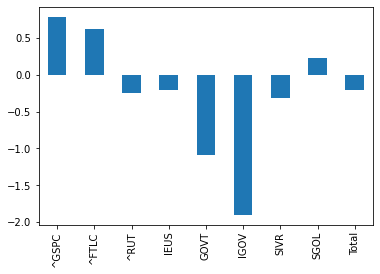

In [46]:
#daily_stock_returns = portfolio_position_values.pct_change().dropna() # Analysing holding such portfolio position from the start
daily_stock_returns = portfolio_test_values.pct_change().dropna()

# To calculate sharpie ratio for individual stocks 
def sharpe_ratio(return_series, N, rf):
    mean = return_series.mean() * N -rf
    sigma = return_series.std() * np.sqrt(N)
    return mean / sigma

N = 252 #252 trading days in a year
rf =0.01 #1% risk free rate
sharpes = daily_stock_returns.apply(sharpe_ratio, args=(N,rf,),axis=0)

sharpes.plot.bar()
sharpes

## Volatility

### Individual Stock Volatility

#### Rolling Volatilty for Each stock

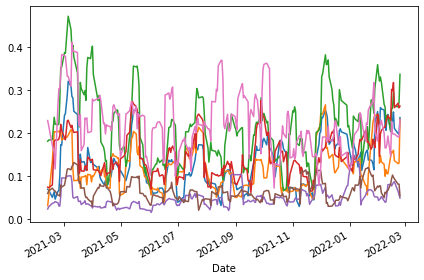

In [101]:
#data = portfolio_position_values.pct_change().dropna() # Analysing holding such portfolio position from the start
rolling_stock = pd.DataFrame()
data = portfolio_test_values.pct_change().dropna()
for stock in all_stocks:
  rolling_stock[stock] = data[stock].rolling(7).std()*(252**0.5)
f1 = plt.figure()
for i in range(0,7):
  rolling_stock.iloc[:,i].plot()
  plt.tight_layout()
  #plt.show() # To display in separate graphs instead of 1

#### Anualised volatility for Each Stock

In [103]:
#data = portfolio_position_values.pct_change().dropna() # Analysing holding such portfolio position from the start
stock_volatility = pd.DataFrame()
data = portfolio_test_values.pct_change().dropna()
tmp = pd.DataFrame()
i = 0 
for stock in all_stocks:
  tmp[stock] = data.iloc[:,i:(i+1)]
  stock_volatility = tmp.std()*(252**0.5)
  i = i + 1
print(stock_volatility)

^GSPC    0.148120
^FTLC    0.129242
^RUT     0.232140
IEUS     0.162255
GOVT     0.053289
IGOV     0.067846
SIVR     0.233496
SGOL     0.133648
dtype: float64


### Portfolio Volatility

#### Just the Anualised Volatility for the Portfolio

In [20]:
total_portfolio_change = portfolio_test_values['Total'].pct_change().dropna()
portfolio_vol = total_portfolio_change.std()*(252**0.5)
portfolio_vol

0.09725466478232812

## Maximum Drawdown

^GSPC   -0.118501
^FTLC   -0.065139
^RUT    -0.209376
IEUS    -0.187752
GOVT    -0.053062
IGOV    -0.118520
SIVR    -0.240117
SGOL    -0.097056
Total   -0.074016
dtype: float64

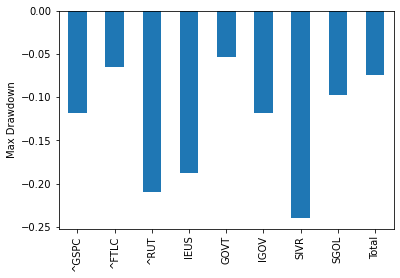

In [104]:
def max_drawdown(return_series):
    comp_ret = (return_series+1).cumprod()
    peak = comp_ret.expanding(min_periods=1).max()
    dd = (comp_ret/peak)-1
    return dd.min()

daily_stock_returns = portfolio_test_values.pct_change().dropna()
max_drawdowns = daily_stock_returns.apply(max_drawdown,axis=0)
max_drawdowns.plot.bar()
plt.ylabel('Max Drawdown')
max_drawdowns

## Compound Annual Growth Rate (CARG)

In [105]:
start_value = portfolio_test_values.iloc[0,:]
end_value = portfolio_test_values.iloc[-1,:]
number_of_years =  round(len(portfolio_test_values)/252)
CARG = (((end_value / start_value) ** (1/number_of_years)) -1)# Shows % of values
CARG

^GSPC    0.120845
^FTLC    0.083713
^RUT    -0.072245
IEUS    -0.035119
GOVT    -0.047681
IGOV    -0.113488
SIVR    -0.088166
SGOL     0.032295
Total   -0.014981
dtype: float64

## Calmar Ratio

^GSPC    1.071736
^FTLC    1.383885
^RUT    -0.233904
IEUS    -0.122640
GOVT    -0.908299
IGOV    -1.012722
SIVR    -0.275645
SGOL     0.425731
Total   -0.142670
dtype: float64

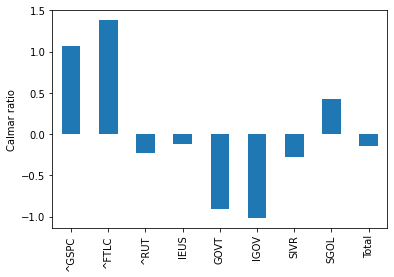

In [106]:
#daily_stock_returns = portfolio_position_values.pct_change().dropna() # Analysing holding such portfolio position from the start
daily_stock_returns = portfolio_test_values.pct_change().dropna()

calmars = daily_stock_returns.mean()*255/abs(max_drawdowns)

calmars.plot.bar()
plt.ylabel('Calmar ratio')
calmars

## Value at Risk? Haven't decided if I want to include this or not